In [1]:
#import needed libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional

from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns

import os

### Load Data

In [2]:
df = pd.read_csv('input_label.csv')

dfX = df['text'].astype(str)
dfY = df['label']

In [3]:
dfXArr = dfX.to_numpy()
dfYArr = dfY.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(dfXArr, dfYArr, test_size= 0.3, random_state=313)

In [4]:
dfX.head()

0    donald trump sends embarrassing new year eve m...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes internet joke thr...
3    trump obsessed even obamas name coded website ...
4    pope francis called donald trump christmas spe...
Name: text, dtype: object

In [5]:
dfY.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

### Data preprocessing (aka tokenization)

Tokenization - direct mapping of a token (a word or a character) to a number

Embedding - create a matrix of feature vector for each token where the size of the feature vector is defined and embedding can be learned

In [6]:
#find average number of tokens per sentence in training dataset
round(sum([len(sentence.split()) for sentence in x_train]) / len(x_train))

242

In [7]:
#declare hyperparameters

# vocabulary range
max_vocab_length = 10000
# chosen to be the average number of tokens per sentence in training set
max_seq_length = 242
# tokenizer will create a token for each word and replace each OOV word with the 'OOV' token
oov_rep = '<OOV>'

trunc_type = 'post'
padding_type = 'post'

embedding_dim = 40

In [8]:
# num_words stores the maximum number of vocabulary words to use when transformations are called
tokenizer = Tokenizer(num_words=max_vocab_length, oov_token=oov_rep)
tokenizer.fit_on_texts(x_train)

# word_index is dictionary where key is a token (in our case, a token is a word)
# and value is the integer representation of the token
word_index = tokenizer.word_index
vocab_size = len(word_index)

print("Vocabulary size: ", vocab_size)

Vocabulary size:  191103


In [9]:
# place train and test data sets into sequences
train_sequence = tokenizer.texts_to_sequences(x_train)
test_sequence = tokenizer.texts_to_sequences(x_test)

In [10]:
# padding handles sentences of different lengths
# with padding_type='post', will pad sequunces of length < maxlen to maxlen
# with trunc_type='post', will truncate sequences of length > maxlen to maxlen by removing values from the end of the sentence
train_padded = pad_sequences(train_sequence, maxlen=max_seq_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequence, maxlen=max_seq_length, padding=padding_type, truncating=trunc_type)

print("x train shape: ", train_padded.shape)
print("x test shape: ", test_padded.shape)

x train shape:  (31428, 242)
x test shape:  (13470, 242)


### Modeling

In [11]:
# model consists of one embedding layer, one ;long short term memory layer, and one output layer
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length),
    tf.keras.layers.Bidirectional(LSTM(100)),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 242, 40)           7644120   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 7,757,121
Trainable params: 7,757,121
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
%%time
# training
num_epochs = 10
checkpoint_path = "lstm_training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

model_history = model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(test_padded, y_test), verbose=2, callbacks=[cp_callback])

Epoch 1/10
983/983 - 378s - loss: 0.0735 - accuracy: 0.9745 - val_loss: 0.0280 - val_accuracy: 0.9901

Epoch 00001: saving model to lstm_training/cp.ckpt
Epoch 2/10
983/983 - 380s - loss: 0.0114 - accuracy: 0.9967 - val_loss: 0.0206 - val_accuracy: 0.9933

Epoch 00002: saving model to lstm_training/cp.ckpt
Epoch 3/10
983/983 - 379s - loss: 0.0060 - accuracy: 0.9982 - val_loss: 0.0234 - val_accuracy: 0.9918

Epoch 00003: saving model to lstm_training/cp.ckpt
Epoch 4/10
983/983 - 370s - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.0291 - val_accuracy: 0.9931

Epoch 00004: saving model to lstm_training/cp.ckpt
Epoch 5/10
983/983 - 367s - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0430 - val_accuracy: 0.9895

Epoch 00005: saving model to lstm_training/cp.ckpt
Epoch 6/10
983/983 - 364s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0361 - val_accuracy: 0.9928

Epoch 00006: saving model to lstm_training/cp.ckpt
Epoch 7/10
983/983 - 364s - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.03

In [13]:
%%time
model.evaluate(test_padded, y_test)

421/421 [==============================] - 37s 88ms/step - loss: 0.0325 - accuracy: 0.9928
CPU times: user 1min 2s, sys: 1.84 s, total: 1min 4s
Wall time: 36.9 s


[0.03254955634474754, 0.9927988052368164]

In [15]:
%%time
# inference
# prediction = model.predict_classes(test_padded)
prediction = (model.predict(test_padded) > 0.5).astype('int32')
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6967
           1       1.00      0.99      0.99      6503

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470

CPU times: user 1min, sys: 1.26 s, total: 1min 1s
Wall time: 34.9 s


In [16]:
# confusion matrix
cf_matrix = confusion_matrix(y_test, prediction)
print(cf_matrix)

[[6938   29]
 [  68 6435]]


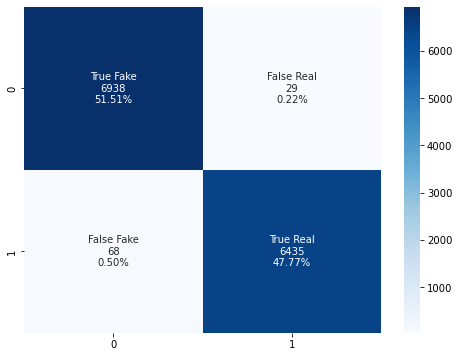

In [17]:
fig, ax = plt.subplots(figsize=(8,6))

group_names = ['True Fake','False Real','False Fake','True Real']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='', ax=ax)
plt.show()

### Another set of test data from politifact.com

In [18]:
politifactDf = pd.read_csv('politifact_labeled.csv')

politifact_x = politifactDf['sources_quote'].astype(str).to_numpy()
politifact_y = politifactDf['label'].to_numpy()

### Tokenize the test data

In [19]:
round(sum([len(sentence.split()) for sentence in politifact_x]) / len(politifact_x))

11

In [20]:
#declare hyperparameters

# chosen to be the average number of tokens per sentence in training set
max_seq_length_pf = 11

In [21]:
# num_words stores the maximum number of vocabulary words to use when transformations are called
tokenizer_pf = Tokenizer(num_words=max_vocab_length, oov_token=oov_rep)
tokenizer_pf.fit_on_texts(politifact_x)

# word_index is dictionary where key is a token (in our case, a token is a word)
# and value is the integer representation of the token
word_index_pf = tokenizer.word_index

In [22]:
politifact_sequence = tokenizer_pf.texts_to_sequences(politifact_x)
politifact_padded = pad_sequences(politifact_sequence, maxlen=max_seq_length_pf, padding=padding_type, truncating=trunc_type)

In [23]:
%%time
model.evaluate(politifact_padded, politifact_y)

492/492 [==============================] - 2s 5ms/step - loss: 2.4609 - accuracy: 0.5763
CPU times: user 3.86 s, sys: 214 ms, total: 4.07 s
Wall time: 2.47 s


[2.4609317779541016, 0.5763412117958069]

In [24]:
%%time
# inference
prediction_pf = (model.predict(politifact_padded) > 0.5).astype('int32')
print(classification_report(politifact_y, prediction_pf))

              precision    recall  f1-score   support

           0       0.64      0.76      0.70     10092
           1       0.37      0.26      0.30      5640

    accuracy                           0.58     15732
   macro avg       0.51      0.51      0.50     15732
weighted avg       0.55      0.58      0.55     15732

CPU times: user 3.86 s, sys: 179 ms, total: 4.04 s
Wall time: 2.44 s


In [25]:
# confusion matrix
cf_matrix_pf = confusion_matrix(politifact_y, prediction_pf)
print(cf_matrix_pf)

[[7626 2466]
 [4199 1441]]


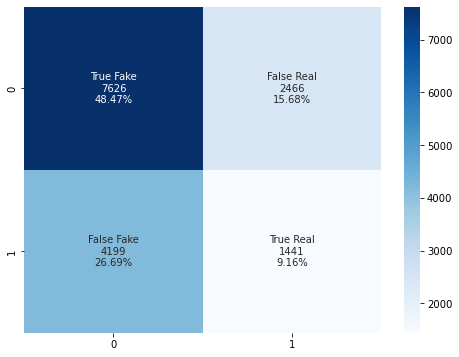

In [26]:
fig, ax = plt.subplots(figsize=(8,6))

group_names = ['True Fake','False Real','False Fake','True Real']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix_pf.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix_pf.flatten()/np.sum(cf_matrix_pf)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_pf, annot=labels, cmap='Blues', fmt='', ax=ax)
plt.show()